# Module 5: Binary Classification

* So far, we have focused on _regression_ tasks where the objective is to predict a scalar continuous value, given some inputs
* In many tasks however, we'd like to predict whether something is or is not (e.g., is a cat or isn't, is a car or isn't, etc)
* Such tasks are called _classification_ tasks because the objective is to classify the input into one of $N$ classes

## Linearly Separable Example

* Consider the figure below. We have two kinds of points: <font color="orange">orange</font> and <font color="blue">blue</font>. They are described by two features, $x_1$ and $x_2$ and distributed as shown in the figure. 

![alt text](figures/simple_binary_classification.png)

* We want a rule that takes a point $p = (x_1, x_2)$ and tells us whether it is orange or blue. 
* A simple rule would be a line: if the point is above the line, predict it to be blue, and if it is below the line, predict it to be orange.
* Ok, so which line should we pick?

![alt text](figures/simple_binary_classification_lines.png)

* Different lines yield different classification accuracies
* The line on the far right is the best as it perfectly classifies all instances

## Nonseparable Example

* Consider the Figure below, can you find a line that separates the orange and blue points?

![alt text](figures/nonseparable_binary_classification.png)

* Here are a few example lines:

![alt text](figures/nonseparable_binary_classification_lines.png)

* We cannot separate the points with just a line
* We'll use a neural net to solve this problem

## Binary Cross-Entropy Loss

* But what should the objective of the neural network be in this case? 
* Mean squared error is inappropriate as there is no notion of distance between predicting orange vs. blue
* We can use accuracy (how many predictions are correct) but that is not a differentiable function
* Recall that a neural network cannot output discrete values, such as 0, 1, 2, etc. It only works with continuous activations.
* Suppose instead that the network outputs the _probability_ that a point is orange. In this case, the standard way is to use an objective or loss function called _cross entropy_:

$$\mathcal{L}(\pi_{i},y_{i})=-(y_{i}log(\pi_{i})+(1-y_{i})log(1-\pi_{i}))$$

* Where $\pi_i$ is the network's output (probability that a point is orange), and $y_i$ is the actual class label: 0 for blue, and 1 for orange.
* Let's plot the function to see how it behaves as the neural network output changes:


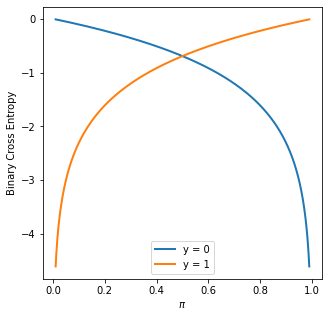

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 


# preds
probs = np.linspace(1e-2, 0.99, 1000)


f, ax = plt.subplots(1, 1, figsize=(5, 5))


# actual class label
actual_label = 0.0
# loss
xe = actual_label * np.log(probs) + (1-actual_label) * np.log(1-probs)

ax.plot(probs, xe, linewidth=2, label='y = 0')

actual_label = 1.0
xe = actual_label * np.log(probs) + (1-actual_label) * np.log(1-probs)
ax.plot(probs, xe, linewidth=2, label='y = 1')
ax.set_xlabel(r'$\pi$')
ax.set_ylabel(r'Binary Cross Entropy')
ax.legend()

* When the actual class label is $1$ (an orange point), the loss approaches $0$ as the probability of an orange point approaches $1$.
* Conversely, when the actual class label is $0$ (a blue point), the loss approaches $0$ as the probability of an orange point approaches $0$.
* The loss heavily penalizes the model if it assigns too low a probability for an orange point, or too high a probability for a blue point.
* What we've just seen is the loss for a single point, what about for a whole collection of points? it is just the average:

$$\mathcal{L}(\boldsymbol{\pi},\boldsymbol{y})=\frac{1}{N}\sum_{i}\mathcal{L}(\pi_{i},y_{i})$$

## Neural Network Implementation

* Armed with a differentiable loss and continuous output, we can implement a neural network model that predicts the color of a point


In [2]:
import numpy.random as rng 
import tensorflow as tf
import sklearn.metrics

# try varying the number of hidden units
n_hidden = 10
eta = 1.0

# read data
data = np.load('data/binary_classification.npz')
X, y = data['X'], data['y']

# move data to tensorflow space
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

# randomly initialize model parameters
W_input_hidden = tf.Variable(rng.randn(X.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, 1), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(1), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]

# create optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

# repeat N times
N = 100
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation
        hidden_activation = tf.tanh(b_hidden + tf.matmul(X, W_input_hidden))
        pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
       
        # loss
        xe_loss = -tf.reduce_mean( y * tf.math.log(pi) + (1-y) * tf.math.log(1-pi) )
        
        #print("LOSS: %0.4f" % (xe_loss.numpy()))
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    gradients = gt.gradient(xe_loss, variables)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients(zip(gradients, variables))

# report results
hidden_activation = tf.tanh(b_hidden + tf.matmul(X, W_input_hidden))
pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
xe_loss = -tf.reduce_mean( y * tf.math.log(pi) + (1-y) * tf.math.log(1-pi) )
print("Final XE: %0.4f" % xe_loss.numpy())

# report results
pi = pi.numpy()
pred_1 = pi > 0.5
acc = np.mean(y.numpy() == pred_1)
print("Accuracy: %0.2f" % acc)

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1


2022-01-10 19:49:07.092479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-10 19:49:07.092591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Final XE: 0.2607
Accuracy: 0.90


### What the network learned

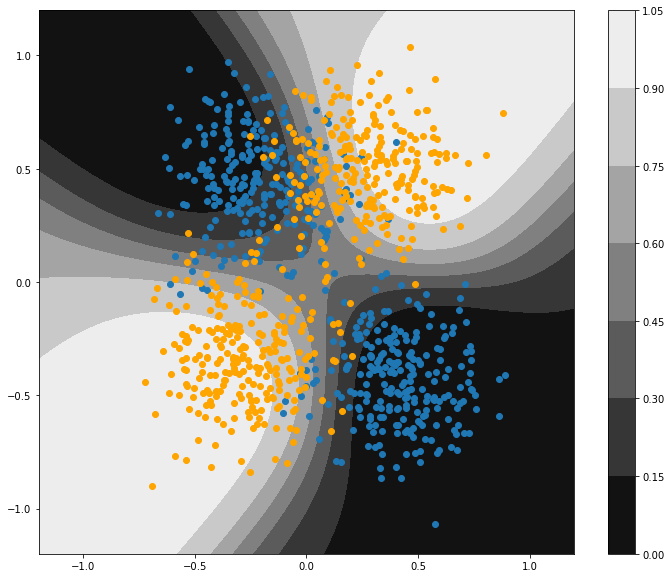

In [3]:
# initialize range of input values
K = 100
xs = np.linspace(-1.2, 1.2, K)
x1s, x2s = np.meshgrid(xs, xs)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T
Xstar = tf.convert_to_tensor(Xstar, dtype=tf.float32)

# predict
hidden_activation = tf.tanh(b_hidden + tf.matmul(Xstar, W_input_hidden))
pi_star = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))

# plot
pi_star = pi_star.numpy().reshape((K, K))

f, ax = plt.subplots(1, 1, figsize=(12, 10))
cp = ax.contourf(x1s, x2s, pi_star, cmap=plt.get_cmap('gist_gray'))

# read data
data = np.load('data/binary_classification.npz')
X, y = data['X'], data['y']

class0_ix = y[:,0] == 0
class1_ix = y[:,0]== 1

ax.scatter(X[class0_ix, 0], X[class0_ix, 1])
ax.scatter(X[class1_ix, 0], X[class1_ix, 1], color='orange')
f.colorbar(cp)

* The model has learned a non linear function that correctly maps out the regions of the two classes.
* Notice how the model is uncertain in the middle region, predicting probability ~ 0.5

## Performance Evaluation

* As you may have noticed, we convert classifier output probability into a hard (orange or blue) decision by outputing orange if the probability is above 0.5

* However, this choice of 0.5 is arbitary; the classifier could output probabilities in the range of 0.3-0.4 for example and so applying this rule would make the classifier predict blue all the time.

* Let's compute accuracy at different thresholds for the following simple example:


In [4]:
y_actual = [0, 1, 1, 0, 1, 1, 0]
y_pred = [0.06, 0.92, 0.86, 0.03, 0.40, 0.70, 0.23]

for thres in np.linspace(0, 1, 9):
    hard_pred = y_pred > thres
    acc = np.mean(hard_pred == y_actual)
    print("Accuracy at %0.2f: %0.2f" % (thres, acc))
        

Accuracy at 0.00: 0.57
Accuracy at 0.12: 0.86
Accuracy at 0.25: 1.00
Accuracy at 0.38: 1.00
Accuracy at 0.50: 0.86
Accuracy at 0.62: 0.86
Accuracy at 0.75: 0.71
Accuracy at 0.88: 0.57
Accuracy at 1.00: 0.43


* The accuracy when the threshold is 0.25 or 0.38 is highest
* We want a metric that characterizes classifier performance at different thresholds
* The standard metric for this is called the Area-Under-the-Receiver-Operating-Characteristic-Curve (AUC-ROC).
* AUC-ROC is the probability that a classifier ranks a positive instance higher than a negative one. That is, it is the probability that a positive instance receives a higher $\pi_i$ value than a negative one.
* AUC-ROC ranges from 0.5 to 1.0, with 0.5 indicating a classifier no better than random coin toss, and 1.0 indicating a perfect classifier.
* The ROC curve is computed by sweeping the thresholds and computing the false negative rate (FNR) and the true positive rate (TPR). 
    * TPR is the proportion of positive instances that the classifier correctly identified $TPR = TP / (TP + FN)$, where $TP$ means true positive, $FN$ means false negative.
    * FNR is the proportion of positive instances that the classifier incorrectly identified as negative $FNR = 1 - TPR$.
* AUC-ROC is then simply the area under the ROC curve.

AUC-ROC: 0.97


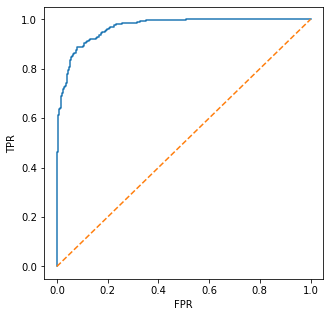

In [5]:
fpr, tpr,_ = sklearn.metrics.roc_curve(y, pi)

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(fpr, tpr)
ax.plot(fpr, fpr, linestyle='dashed')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
auc_roc = sklearn.metrics.roc_auc_score(y, pi)
print("AUC-ROC: %0.2f" % auc_roc)

## Recap

* Problems where the objective is to predict whether something is or is not are known as binary classification problems
* To train NNs on binary classification problems, we use the cross entropy objective function
* NNs only output probabilities, those need to be converted to a hard decision via a thresholding function to compute metrics such as accuracy
* The AUC-ROC metric is a single number that characterizes the performance of a binary classifier under different thresholds